# Welcome!

In this notebook, we provide the code for running and collecting experimental results as described in the paper:

[**Sanity Checks Revisited: An Exploration to Repair the Model Parameter Randomisation Test**](https://openreview.net/forum?id=vVpefYmnsG) by Anna Hedström, Leander Weber, Sebastian Lapuschkin, Marina Höhne. 

Please note that this notebook assumes access to test sets for the `MNIST`, `fMNIST`, and `ImageNet` datasets. If you haven't generated the necessary data yet, please refer to our tutorial [here](https://github.com/annahedstroem/MetaQuantus/blob/main/tutorials/Tutorial-Data-Generation-Experiments.ipynb) to generate the required dataset.

Make sure to update file paths as needed before running the experiments (e.g., `nbs/temp_results/` and `nbs/temp_results/plots/`. Also enable GPU as some experiments are quite computationally costly.


### Imports

In [1]:
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output()

In [2]:
# Load supporting functions.
import sys
sys.path.append('../')

from src import *

In [3]:
# Import libraries.
import quantus
import metaquantus

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
import pickle
from collections import defaultdict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
try:
    print('Using device:', torch.cuda.get_device_name(0))
    !nvidia-smi
except:
    pass

In [4]:
# Set paths to datasets and to write results.
path_assets =  "/content/drive/MyDrive/Projects/neurips_xai_workshop/assets/"
path_results = "/content/drive/MyDrive/Projects/neurips_xai_workshop/results_#2/"

In [5]:
path_assets =  "../../MetaQuantus/assets/"
path_results = "temp_results/"

### Plot MPRT vs eMPRT curves

In [6]:
# Load datasets, models and explanations.
datasets = {
    "MNIST_LeNet": {
        "batch_size": 1000,
        "full_size": 1000,
        "fig_size": (4, 4),
    },
    "fMNIST_LeNet": {
        "batch_size": 1000,
        "full_size": 1000,
        "fig_size": (4, 4),
    },
    "ImageNet_ResNet18": {
        "batch_size": 100,
        "full_size": 300,
        "fig_size": (8, 4),
    },
    "ImageNet_VGG16": {
        "batch_size": 25,
        "full_size": 300,
        "fig_size": (8, 4),
    },
}
xai_methods = [
    "Control Var. Random Uniform",
    "Gradient",
    "Saliency",
    "LayerGradCam",
    "SmoothGrad",
    "IntegratedGradients",
    "LRP-Eps",
    "LRP-Z+",
    "Guided-Backprop",
    "GradientShap",
    "InputXGradient",
]
# Parameterise the metrics.
metrics = [
    quantus.EfficientMPRT(
        layer_order="bottom_up",
        complexity_func=quantus.complexity_func.discrete_entropy,
        complexity_func_kwargs={"n_bins": 100},
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=False,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
        compute_extra_scores=True,
    ),
    quantus.SmoothMPRT(
        layer_order="bottom_up",
        nr_samples=50,
        noise_magnitude=0.1,
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
    ),
    quantus.MPRT(
        layer_order="top_down",
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
    ),
]

In [7]:
debug = True
generate_data = False

if generate_data:
    for metric in metrics:

        torch.cuda.empty_cache()
        scores = {}
        for meta_name, meta_data in datasets.items():
            scores[meta_name] = {}
            dataset_name, model_name = meta_name.split("_")

            # Get datasst settings.
            dataset_settings = setup_experiments(
                dataset_name=dataset_name, path_assets=path_assets, device=device
            )
            estimator_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]
            dataset_kwargs = dataset_settings[dataset_name]

            # Get the model.
            model = dataset_kwargs["models"][model_name]

            # Setup for batch processing.
            nr_batches = int(meta_data["full_size"] / meta_data["batch_size"])

            temp_batches = {}
            for batch_id in range(nr_batches):

                # Get the data for the batch.
                start_idx = batch_id * meta_data["batch_size"]
                end_idx = start_idx + meta_data["batch_size"]
                x_batch = dataset_kwargs["x_batch"][start_idx:end_idx]
                y_batch = dataset_kwargs["y_batch"][start_idx:end_idx]
                s_batch = dataset_kwargs["s_batch"][start_idx:end_idx]

                # Update model-specific xai parameters.
                xai_methods_with_kwargs = {**setup_xai_methods_captum(
                    xai_methods=xai_methods,
                    x_batch=x_batch,
                    gc_layer=dataset_kwargs["gc_layers"][model_name],
                    img_size=estimator_kwargs["img_size"],
                    nr_channels=estimator_kwargs["nr_channels"],
                    nr_segments=50,
                ), **setup_xai_methods_zennit(xai_methods=xai_methods, model=model)}

                for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():

                    scores[meta_name][xai_method] = {}

                    if batch_id == 0:
                        temp_batches[xai_method] = {
                            "model_scores": [], 
                            "explanation_scores": [], 
                            "correlation_scores": [],
                            "evaluation_scores": [],
                            "similarity_scores": [],
                        }

                    if debug:
                        start = time.time()
                        print(f"batch id {batch_id} - {xai_method} ({model_name}, {dataset_name})")

                    metric.abs = True
                    if xai_method == "SmoothGrad":
                        metric.abs = True

                    # Score!
                    evaluation_scores = metric(model=model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        softmax=True,
                        a_batch=None,
                        device=device,
                        explain_func=quantus.explain,
                        explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs},
                    )

                    # Save intermediate batch results.
                    try:
                        temp_batches[xai_method]["model_scores"].append(metric.model_scores_by_layer)
                        temp_batches[xai_method]["explanation_scores"].append(metric.explanation_scores_by_layer)
                        temp_batches[xai_method]["correlation_scores"].extend(metric.scores_extra["scores_correlation_model_vs_explanation_complexity"])
                    except Exception as e:
                        print(f"Error message: {e}")

                    if metric.name != "Model Parameter Randomisation Test":
                        temp_batches[xai_method]["similarity_scores"].extend(evaluation_scores)
                    else:
                        temp_batches[xai_method]["evaluation_scores"].extend(evaluation_scores)

                    if debug:
                        for k, v in temp_batches[xai_method].items():
                            try:
                                if all((isinstance(val, (int, float)) and (val == 0 or np.isnan(val))) for val in v):
                                    print(f"\t\tWarning: '{k}' - with all NaNs or zeros!")
                            except TypeError:
                                pass 
                            if isinstance(v, list) and not v:
                                print(f"\t\tWarning:{k} - list is empty!")

                        print(f"\t\t\t{evaluation_scores}")
                        print(f"\tTime to compute {time.time()-start:.2f} secs.")

                    torch.cuda.empty_cache()

            # Merge dictionaries for different batches.
            for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():
                for k in temp_batches[xai_method].keys():
                    if isinstance(temp_batches[xai_method][k][0], dict):

                        # Merge all dicts according the the same key!
                        merged_dict = defaultdict(list)
                        for d in temp_batches[xai_method][k]:
                            for inner_k, v in d.items():

                                # Extend the list of float values.
                                merged_dict[inner_k].extend(v)  

                        # Replace the list of dictionaries with the merged dictionary.
                        temp_batches[xai_method][k] = dict(merged_dict)

            # Put the results back to scores dictionary.
            for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():
                for k in temp_batches[xai_method].keys():
                    scores[meta_name][xai_method] = temp_batches[xai_method]

        # Save data for each metric.
        with open(path_results+f"{metric.name}_curves_scores.pickle", 'wb') as f:
            pickle.dump(scores, f)

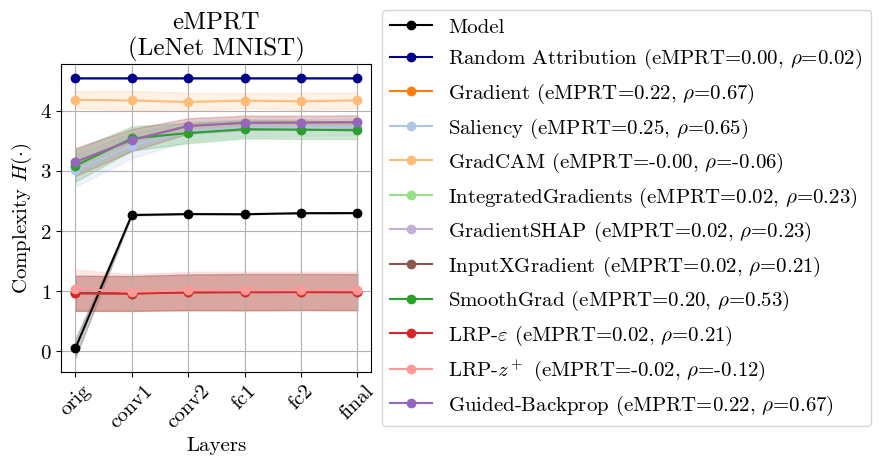

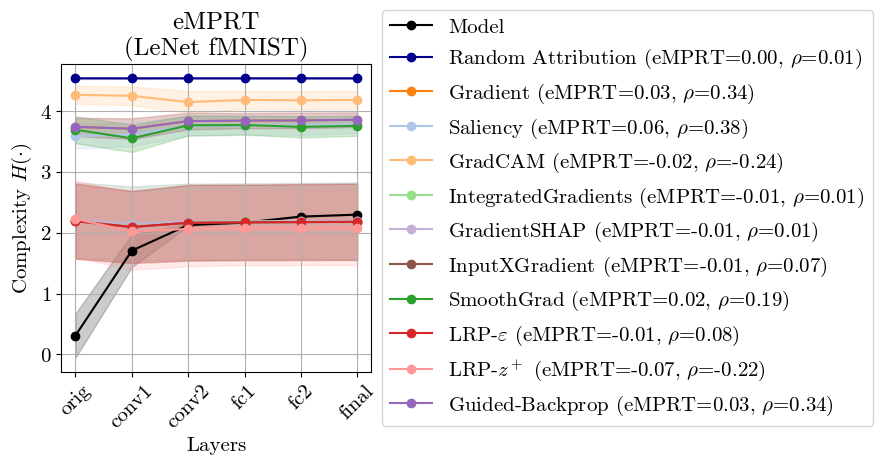

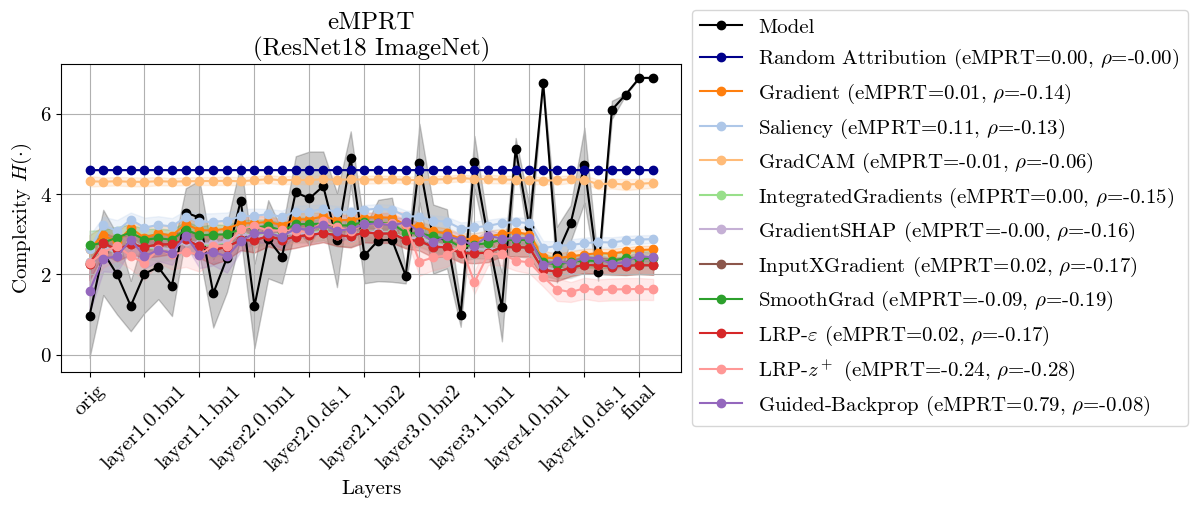

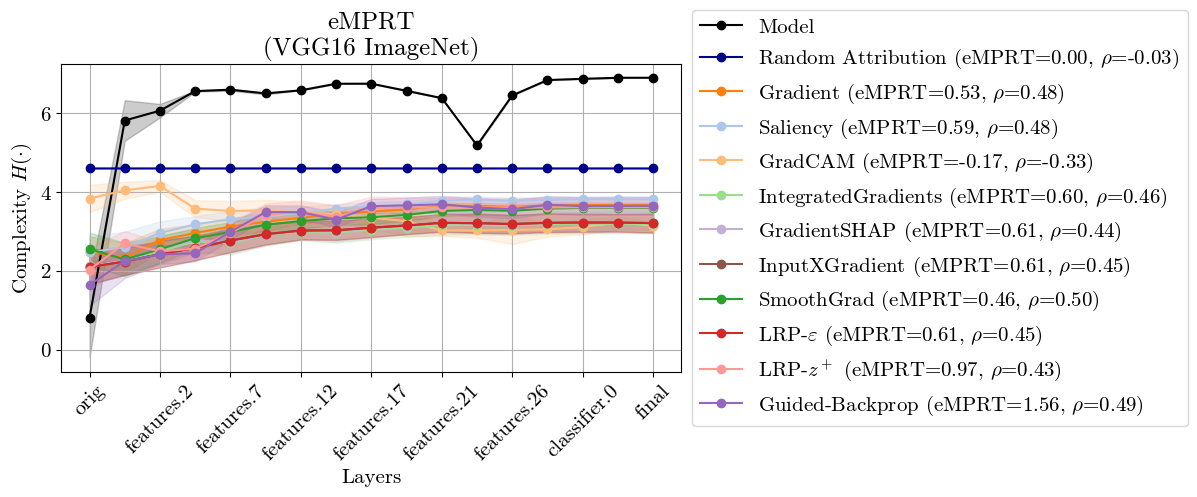

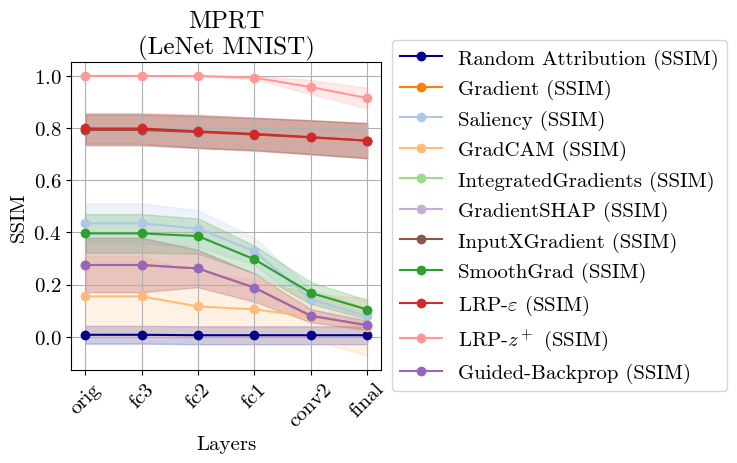

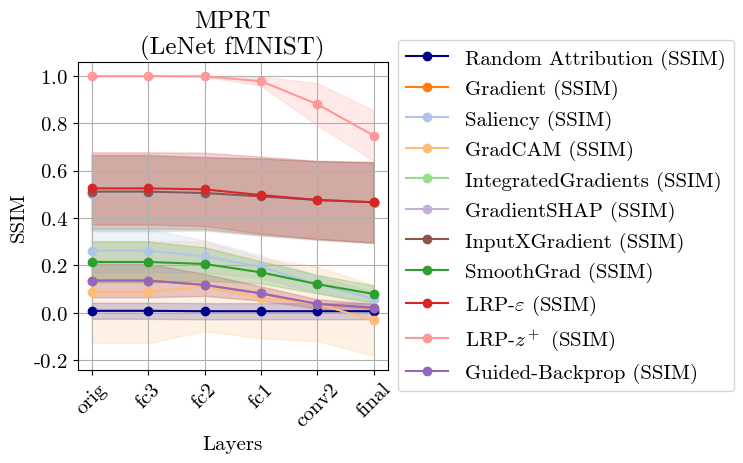

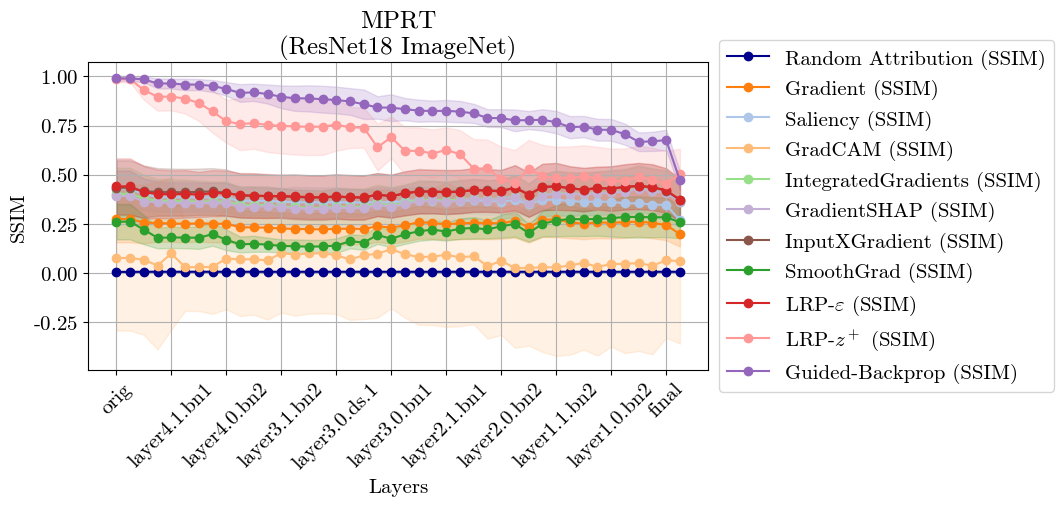

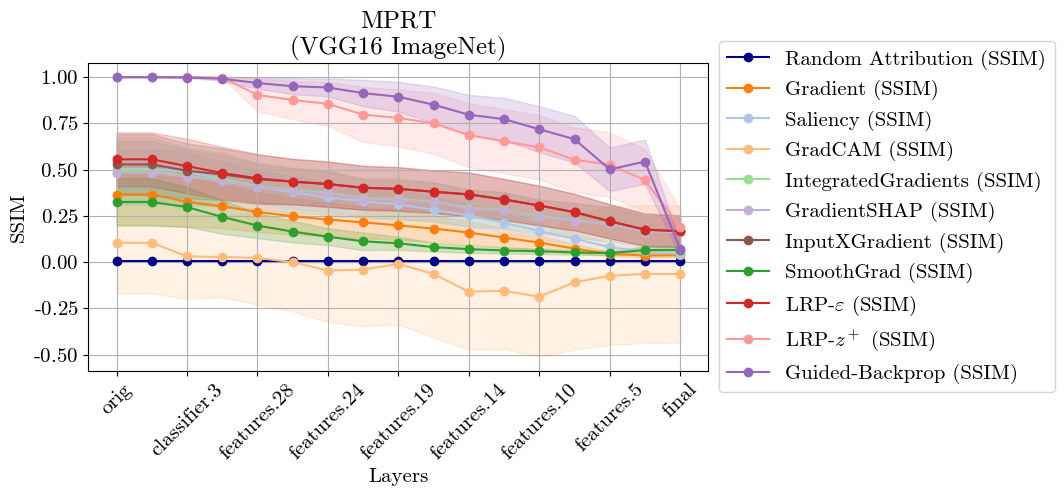

In [8]:
def plot_curves(path_results: str,
                metric_name: str = "MPRT",
                plotting_func: Callable = plot_randomisation_curves,
                ):
    # Load data.
    with open(path_results+f"{metric_name}_curves_scores.pickle", 'rb') as f:
        scores = pickle.load(f)

    for meta_name, meta_data in datasets.items():
        dataset_name, model_name = meta_name.split("_")

        # Plot!
        
        plot_randomisation_curves(scores[meta_name],
                    dataset_name,
                    model_name,
                    metric_name=metric_name,
                    figsize=meta_data["fig_size"]) # (10, 6)) (min(len(list(model.modules())), 10), 4)

        plt.savefig(path_results+f"plots/{metric_name}_curves_{dataset_name}_{model_name}.svg")
        plt.savefig(path_results+f"plots/{metric_name}_curves_{dataset_name}_{model_name}.pdf")
        plt.show()

plot_curves(path_results, metric_name="eMPRT")
plot_curves(path_results, metric_name="MPRT")

### Benchmarking

In [9]:
# Experimental setup.
xai_methods = {
    "G_GC": ["Gradient", "LayerGradCam"],
    "SA_LRPplus_IXG": ["Saliency", "LRP-Z+", "InputXGradient"],
    "G_GC_LRPeps_GB": ["Gradient", "LayerGradCam", "LRP-Eps", "Guided-Backprop"],
    "GP_GS_GC_LRP-Eps_SA": ["Guided-Backprop", "GradientShap", "LayerGradCam", "LRP-Eps", "Saliency"],
    "full_set": ["Gradient", "Saliency", "LayerGradCam",  "SmoothGrad", "IntegratedGradients",
            "LRP-Eps", "LRP-Z+", "Guided-Backprop", "GradientShap", "InputXGradient"]
}
datasets = {
    "MNIST": {
        "model_name": "LeNet",
        "indices": [[0,1000]],
        },
    "fMNIST": {
        "model_name": "LeNet",
        "indices": [[0,1000]],
        },
     "ImageNet_ResNet18": {
        "model_name": "ResNet18",
        "indices": get_indices(batch_size=100),
        },
    "ImageNet_VGG16": {
        "model_name": "VGG16",
        "indices": get_indices(batch_size=25),
        },
    }

In [ ]:
# Run benchmarking.
xai_round = "G_GC"
fname = xai_round+""

if __name__ == "__main__":
    for dataset_name, meta in datasets.items():
        dataset_name = dataset_name.split("_")
        dataset_name = dataset_name[0]
        for i in range(len(meta["indices"])):
            torch.cuda.empty_cache()
            start_idx, end_idx = meta["indices"][i][0], meta["indices"][i][1]
            benchmark = run_benchmarking_script(dataset_name=dataset_name,
                                                model_name=meta["model_name"],
                                                K=str(5),
                                                iters=str(3),
                                                xai_methods=xai_methods[xai_round],
                                                normalise=True,
                                                start_idx=str(start_idx),
                                                end_idx=str(end_idx),
                                                path_assets=path_assets,
                                                path_results=path_results,
                                                setup_metrics=setup_estimators,
                                                folder="benchmarking/",
                                                fname_addition=fname)
            torch.cuda.empty_cache()